In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes, plot_FP_jitter, make_FP_axs
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [2]:
def plot_FP_jitter_2D(m,D_use,rule,t_num,fp_epoch,sorted_fps,fp_inds,qvals,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,unstable_qlim = -6,c = 'k'):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
        for jit in range(n_jit):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = 3)
            plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = 3)

In [3]:
model_n = 1
task_list = ['dmcgo','dmcnogo']
rule = task_list[0]
which_net = 'l2w0001'
fldr = 'all_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','figure6')
if not os.path.exists(figpath):
    os.makedirs(figpath)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


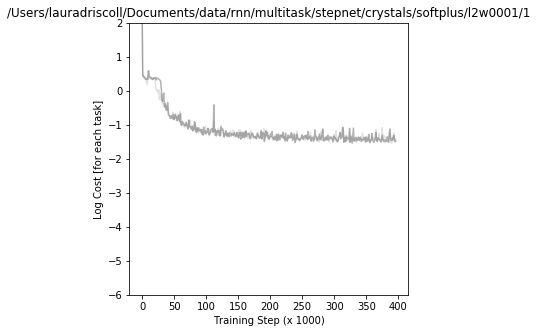

In [4]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [18]:
rule = 'dmcgo'
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt


In [19]:
np.shape(trial.x)

(135, 80, 25)

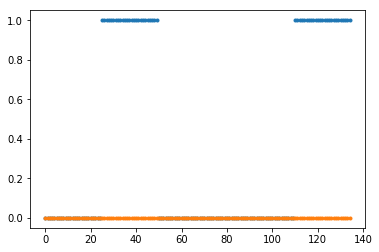

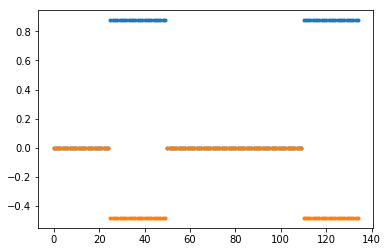

In [33]:
t1=20
t2=28
plt.plot(trial.x[:,t1,1:3],'.')
plt.show()
plt.plot(trial.x[:,t2,1:3],'.')
plt.show()

In [11]:
fp_epoch = 'stim1'
ind = -1
rule = task_list[0]
T_inds = get_T_inds(trial_all[rule],fp_epoch)
B,N = np.shape(h_all[rule][T_inds[ind],:,:])
R = np.zeros((len(task_list)*B*len(T_inds),N))
Y = np.zeros((7,len(task_list)*B*len(T_inds)))

for rule_i in range(len(task_list)):
    rule = task_list[rule_i]
    T_inds = get_T_inds(trial_all[rule],fp_epoch)[-2:-1]
    r = np.reshape(h_all[rule][T_inds,:,:],(len(T_inds)*B,N))
    
    isanti = 'anti' in task_list[rule_i]
    nogo = 'nogo' in task_list[rule_i] 
    ismemory = 'delay' in task_list[rule_i]
    y_anti = isanti*np.ones((np.shape(r)[0],1))+nogo*np.ones((np.shape(r)[0],1))
    y_memory = ismemory*np.ones((np.shape(r)[0],1))
    y_stim = np.repeat(np.min(trial_all[rule].stim_locs[:,[0,2]],axis=1),len(T_inds))
    y_out = np.repeat(trial_all[rule].y_loc[-1,:],len(T_inds))
    
    inds = range((B*len(T_inds))*rule_i,(B*len(T_inds))*(rule_i+1))
    
    R[inds,:] = r
    Y[0,inds] = np.expand_dims(isanti,axis = 0)
    Y[1,inds] = np.expand_dims(ismemory,axis = 0)
    Y[2,inds] = np.expand_dims(np.sin(y_stim),axis = 0)
    Y[3,inds] = np.expand_dims(np.cos(y_stim),axis = 0)
    Y[4,inds] = np.expand_dims(np.sin(y_out),axis = 0)
    Y[5,inds] = np.expand_dims(np.cos(y_out),axis = 0)
    Y[6,inds] = np.repeat(T_inds,B)
    
    Y_labels = ['ANTI','MEMORY','STIM '+ r' $\cos{\theta}$','STIM '+ r' $\sin{\theta}$',
                'OUT '+ r' $\cos{\theta}$','OUT '+ r' $\sin{\theta}$','TIME']
    
lm = linear_model.LinearRegression()
model = lm.fit(Y.T,R)
Beta = model.coef_
Beta_qr,_ = LA.qr(Beta)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001_l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001_l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents

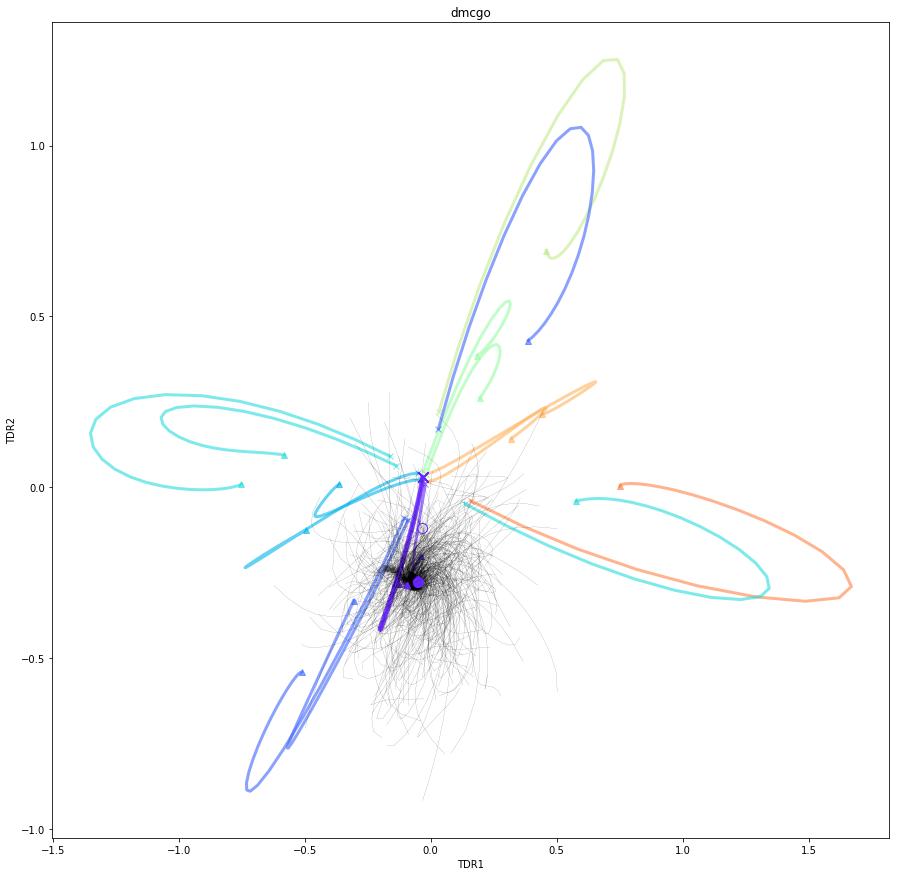

In [30]:
from tools_lnd import comp_eig_decomp

epoch = 'stim1'
rule_set = ['dmcgo','dmcnogo']
rule = rule_set[0]
t_set = [18.0,46.8]
si = 0
t_num = 0
axs = 'pca_h'
f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[si])+'.npz')
fp_struct = np.load(f)
sorted_fps = fp_struct['xstar']
fp_inds = range(len(sorted_fps))
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
D_use,_,_ = make_FP_axs(f,m,rule,epoch,axs =axs, clust = 'False')

fig = plt.figure(figsize=(15, 15))

plot_FP_jitter(m,D_use,rule,t_num,epoch,sorted_fps,fp_inds,eig_decomps,rule_set,
               xlabel = 'TDR1',ylabel = 'TDR2',rand_step_coef = 0.2,n_steps = 50,
               lw = 3,al = .6,linestyle = '-',n_jit = 20,c_master = 'x_locs')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001_l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001_l2w0001/0/model.ckpt


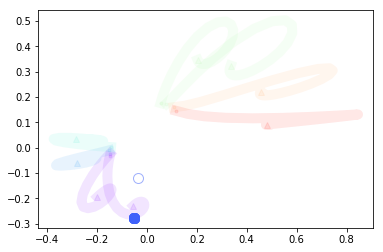

In [31]:
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
       linestyle = '-', alpha = .1, cmap_c = 'rainbow')
plot_FP(sorted_fps, D_use.T, eig_decomps, c=cmap(res[1]/360),al = .5, lw = 1)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

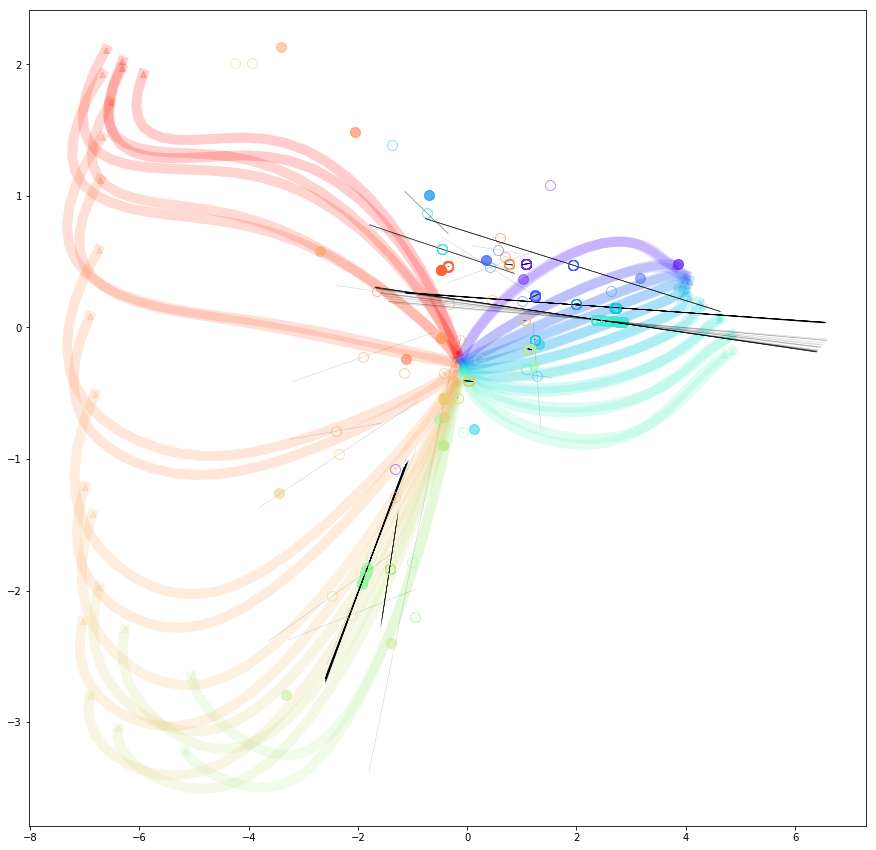

In [12]:
from os import listdir
from os.path import isfile, join
from tools_lnd import comp_eig_decomp

# dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
# m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

cmap = plt.get_cmap('rainbow')
fig = plt.figure(figsize=(15, 15))

epoch_list = ['stim1',]
epoch = epoch_list[0]
trial_set = range(80)

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
_,x = gen_X_from_model_dir(m,trial)
T_inds = get_T_inds(trial,epoch)

D_use = make_axes(m,rule,epoch)
x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
       linestyle = '-', alpha = .1, cmap_c = 'rainbow')

f_path = os.path.join(m,'tf_fixed_pts_all_init',rule)
all_files = [f for f in listdir(f_path) if isfile(join(f_path, f))]

for ei in range(len(epoch_list)):

    epoch = epoch_list[ei]

    epoch_files = [f for f in all_files if f[0]==epoch[0]]

    for epoch_file in epoch_files:
                
        f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch_file)
        fp_struct = np.load(f)
        sorted_fps = fp_struct['xstar']
        fp_inds = range(len(sorted_fps))
        eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
        
        temp = re.findall(r'\d+', epoch_file) 
        res = list(map(int, temp))

        plot_FP(sorted_fps, D_use.T, eig_decomps, c=cmap(res[1]/360),al = .5, lw = 1)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

NameError: name 'compress' is not defined

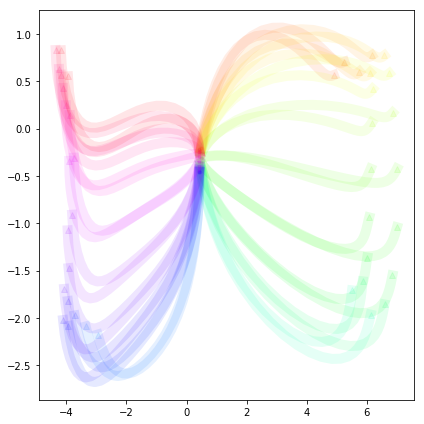

In [16]:
########## X STIM ###########

fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
t_set = [18.0,46.8]
trial_num = [int(10*t/36) for t in t_set]
n_interp = 20
n_fps_init = 60
n_fps = 60
trial_set = range(0,80,2)
rule_set = [task_list[0],]
epoch_set = ['stim1',]
step_file = 'interp_stim'
axs = 'tdr'
linestyle = ['-','--']

ei = 0
epoch = epoch_set[ei]
ri = 0
rule = rule_set[ei]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)

stim_axs = 0
f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[stim_axs])+'.npz')
D_use,_,_ = make_FP_axs(f,m,rule,epoch,axs =axs, clust = 'False')
epoch_name, rule_name, _, _ = take_names(epoch,rule)
axes_label1 =  epoch_name +' '+ axs + ' 1'
axes_label2 = epoch_name +' '+ axs + ' 2'

# use_yinds = [2,4]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]

# D_use = Beta_qr[:,use_yinds]
# D_use[:,1] = w_out[:,2]
# axes_label2 = 'sin out'

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['darkorchid','orange']

_,x = gen_X_from_model_dir(m,trial)
T_inds = get_T_inds(trial,epoch_set[0])
x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
       linestyle = linestyle[ri], alpha = .1)
    
for si in range(len(t_set)):
    ax = plt.subplot(111)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[si])+'.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)
#     print(np.log10(qvals))
    
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
    stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

    plt.plot(fp_project[:,0],fp_project[:,1],'o',c = cmap_discrete[si],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
    plt.plot(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],'o',c = cmap_discrete[si],
             markersize = 10, alpha = 1,linewidth = 5)
    
#     _,x = gen_X_from_model_dir(m,trial)
#     T_inds = get_T_inds(trial,epoch)
#     x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

#     X_trial = np.dot(x_epoch[trial_set[si],:,:],D_use)
#     plt.plot(X_trial[:,0],X_trial[:,1],c = cmap_discrete[si],linewidth = 2, 
#            linestyle = linestyle[ri], alpha = 1)
    
    plot_FP_jitter_2D(m,D_use,rule,trial_num[si],epoch,sorted_fps,range(len(sorted_fps)),qvals,
                      rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 50,
                      n_jit = 1,unstable_qlim = -10,c = cmap_discrete[si])

#     for step_i in range(n_interp):
        
#         f = rule+'_'+epoch+'_'+str(t_set[0])+'_'+str(t_set[1])+'_step_'+str(step_i)
#         filename = os.path.join(m,step_file,rule,f+'.npz')
#         fp_struct = np.load(filename)
#         step_fps = fp_struct['xstar']

#         fp_project = np.dot(step_fps,D_use)
#         plt.plot(fp_project[:,0],fp_project[:,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp))
        
tit = rule_name+ ' X STIM'
plt.title(tit,fontsize = 18)
plt.xlabel(axes_label1,fontsize = 18)
plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+str(t_set[1])+'_'+tit+'.pdf'
plt.savefig(os.path.join(figpath,step_file,figname),dpi = 30)
figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+str(t_set[1])+'_'+tit+'.png'
plt.savefig(os.path.join(figpath,step_file,figname),dpi = 30)
plt.show()

In [45]:
np.array([ 0.94901961,  0.95294118,  0.95686275])/10

array([0.09490196, 0.09529412, 0.09568628])

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

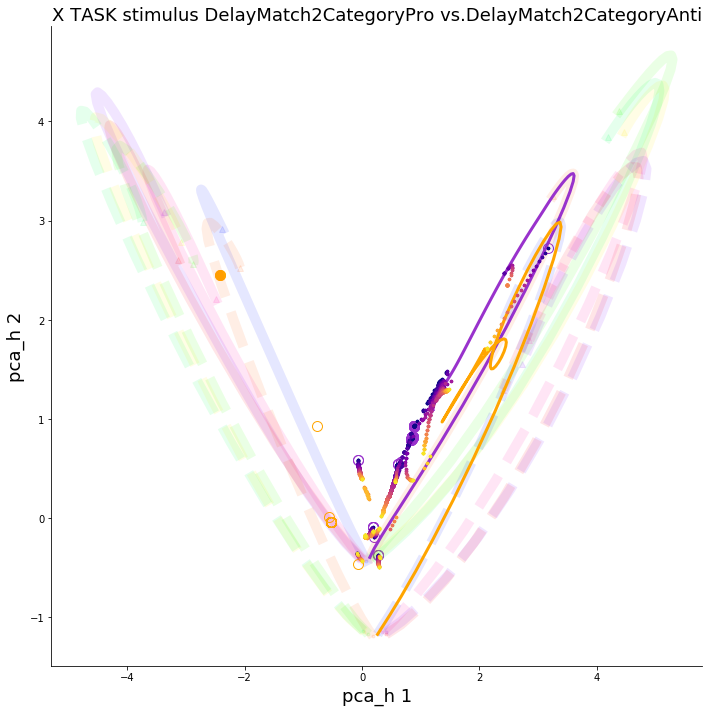

In [15]:
########## X TASK ###########

fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
n_interp = 20
t_set = [18,18]
trial_num = [0,0]
trial_set = range(0,80,10)
rule_set = ['dmcgo','dmcnogo']
rule = rule_set[0]
epoch_set = ['stim1',]
step_file = 'interp_tasks'
linestyle = ['-','--']
axs = 'pca_h'

trial_str = '_'.join(str(t) for t in trial_num)
rule_str = '_'.join(str(r) for r in rule_set)

ei = 0
epoch = epoch_set[ei]

# rule_axs = 0
# use_yinds = [4,5]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]
# D_use = Beta_qr[:,use_yinds]

# f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
# D_use,_,_ = make_FP_axs(f,m,rule,epoch,axs =axs, clust = 'False')

# D_use[:,1] = w_out[:,2]
# axes_label2 = 'out sin'

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['darkorchid','orange']

# _,x = gen_X_from_model_dir(m,trial)
# T_inds = get_T_inds(trial,epoch_set[0])
# x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
# plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
#        linestyle = linestyle[ri], alpha = .1,cmap_c = 'hsv')

rule_axs = 0
f = os.path.join(m,'tf_fixed_pts_all_init',rule_set[rule_axs],epoch+'_'+str(t_set[rule_axs])+'.0.npz')
D_use,_,_ = make_FP_axs(f,m,rule_set[rule_axs],epoch,axs =axs, clust = 'False')
epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'


for ri in range(len(rule_set)):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    ax = plt.subplot(111)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)
#     print(np.log10(qvals))
    
    stable_fp = np.log10(qvals)<-6
    plt.plot(fp_project[stable_fp==1,0],fp_project[stable_fp==1,1],'o',c = cmap_discrete[ri],
             markersize = 10, alpha = 1,linewidth = 2)
    plt.plot(fp_project[stable_fp==0,0],fp_project[stable_fp==0,1],'o',c = cmap_discrete[ri],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 2)
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[0])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
           linestyle = linestyle[ri], alpha = .1)
    
    plot_FP_jitter_2D(m,D_use,rule,trial_num[ri],epoch,sorted_fps,range(len(sorted_fps)),qvals,
                  rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 100,
                  n_jit = 1,unstable_qlim = -10,c = cmap_discrete[ri])

    for step_i in range(n_interp):
        f = rule_set[0]+'_'+rule_set[1]+'_'+epoch_set[0]+'_'+str(t_set[0])+'_'+str(t_set[0])+'_step_'+str(step_i) #+'_'+str(t_set[0])
        filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],f+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']
#         print(len(step_fps))

        fp_project = np.dot(step_fps,D_use)
        plt.plot(fp_project[:,0],fp_project[:,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp))
#         plt.show()

tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
plt.title(tit,fontsize = 18)
plt.xlabel(axes_label1,fontsize = 18)
plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xlim((-10,10))
# plt.ylim((-10,10))

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
    
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+str(trial_num[0])+'_'+str(trial_num[0])+'_'+tit
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [49]:
os.path.join(figpath,step_file,figname+'.png')

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure3/interp_tasks/pca 1_pca 2_delayanti_delay1_0_0_X TASK memory MemoryPro vs.MemoryAnti.png'

stim1
go1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001_l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001_l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


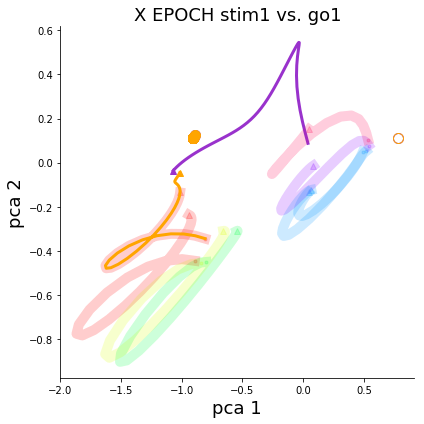

In [28]:
########## X EPOCH ###########

fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
t_set = [18.0,18.0]
trial_num = [0,0]
trial_set = range(0,80,10)
rule_set = ['dmcgo',]
epoch_set = ['stim1','go1']
step_file = 'interp_epochs'
linestyle = ['-','--']
axs ='pca'

ri = 0
rule = rule_set[ri]
epoch_axs = 0

f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch_set[epoch_axs]+'_'+str(t_set[epoch_axs])+'.npz')
D_use,_,_ = make_FP_axs(f,m,rule,epoch_set[epoch_axs],axs =axs, clust = 'False')
epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule_set[0])
epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule_set[0])
axes_label1 = axs + ' 1'
axes_label2 = axs + ' 2'

# use_yinds = [4,5]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]

# D_use = Beta_qr[:,use_yinds]
# D_use[:,1] = w_out[:,2]
# axes_label2 = 'sin out'

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['darkorchid','orange']

for ei in range(len(epoch_set)):
    ax = plt.subplot(111)
    
    epoch = epoch_set[ei]
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)
#     print(np.log10(qvals))
    
    stable_fp = np.log10(qvals)<-6
    plt.plot(fp_project[stable_fp==1,0],fp_project[stable_fp==1,1],'o',c = cmap_discrete[ei],
             markersize = 10, alpha = 1, linewidth = 2)
    plt.plot(fp_project[stable_fp==0,0],fp_project[stable_fp==0,1],'o',c = cmap_discrete[ei],
             markersize = 10, markerfacecolor = 'none', alpha = 1, linewidth = 2)
    
#     _,x = gen_X_from_model_dir(m,trial)
#     T_inds = get_T_inds(trial,epoch)
#     x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
#     plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 2, linestyle = linestyle[ei])
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[1])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
           linestyle = linestyle[ri], alpha = .1)
    
    plot_FP_jitter_2D(m,D_use,rule,trial_num[ei],epoch,sorted_fps,range(len(sorted_fps)),qvals,
              rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 50,
              n_jit = 1,unstable_qlim = -10,c = cmap_discrete[ei])

#     for step_i in range(20):
#         f = rule_set[0]+'_'+epoch_set[0]+'_'+epoch_set[1]+'_'+str(t_set[ri])+'_step_'+str(step_i)
#         filename = os.path.join(m,step_file,rule_set[0],f+'.npz')
#         fp_struct = np.load(filename)
#         step_fps = fp_struct['xstar']
# #         print(len(step_fps))

#         fp_project = np.dot(step_fps,D_use)
#         plt.plot(fp_project[:,0],fp_project[:,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp))
        
tit = 'X EPOCH ' + epoch_set[0]+' vs. '+epoch_set[1]
plt.title(tit,fontsize = 18)
plt.xlabel(axes_label1,fontsize = 18)
plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [46]:
os.path.join(figpath,step_file,figname+'.pdf')

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure3/interp_epochs/pca 1_pca 2_delaygo_delay1_0_X EPOCH stim1 vs. delay1.pdf'